In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os

FRAC_ADMIT = 0.5


In [3]:


###
## Load dataframe where each row is a single applicant
###

df = pd.read_csv('./df_test.csv')
df['key'] = df['R'].astype(str) + "_"  + df['T'].astype(str)



In [4]:
df['Y_stratum'] = df['Y'].astype(str) + df['Y_reject'].astype(str)



In [5]:
###
## Get number of people in each stratum
###

dff = df[['R','T','key','Y','Y_reject']].groupby(['R','T','Y','Y_reject']).count().reset_index()
dff.columns = ['R','T','Y','Y_reject','N']

In [6]:
TOTAL_ADMITS = int(len(df)*FRAC_ADMIT)
MAX_BLACK_ADMITS = len(df[df['R']==1])
MIN_GRADUATES = 10000
GRID_SIZE = 100

outcomes_grid = []
Xs = []
Ys = []

for N_black_admits in range(0,MAX_BLACK_ADMITS):
    
    if N_black_admits % GRID_SIZE != 0:
        continue
    
    black_admits = df[df['R']==1].sort_values(by='T',ascending=False).head(n=N_black_admits)
    white_admits = df[df['R']==0].sort_values(by='T',ascending=False).head(n=TOTAL_ADMITS-N_black_admits)
    
    Y = black_admits['Y'].sum() + white_admits['Y'].sum()
    
    Xs.append(N_black_admits)
    Ys.append(Y)
    print(N_black_admits,Y)
    
    for y_iter in np.arange(MIN_GRADUATES,Y,GRID_SIZE):
        outcomes_grid.append({'min_black_admits':N_black_admits-GRID_SIZE/2, 'max_black_admits':N_black_admits+GRID_SIZE/2, 'max_graduates':y_iter+GRID_SIZE, 'min_graduates':y_iter, 'policy_exists':'Unknown'})
        

0 29333
100 29381
200 29447
300 29503
400 29542
500 29595
600 29637
700 29682
800 29719
900 29756
1000 29802
1100 29842
1200 29883
1300 29908
1400 29943
1500 29968
1600 29996
1700 30028
1800 30045
1900 30084
2000 30102
2100 30142
2200 30181
2300 30206
2400 30235
2500 30260
2600 30285
2700 30306
2800 30335
2900 30359
3000 30386
3100 30423
3200 30451
3300 30475
3400 30511
3500 30536
3600 30545
3700 30560
3800 30580
3900 30594
4000 30608
4100 30638
4200 30646
4300 30662
4400 30672
4500 30686
4600 30709
4700 30732
4800 30750
4900 30778
5000 30785
5100 30788
5200 30785
5300 30792
5400 30805
5500 30817
5600 30828
5700 30836
5800 30846
5900 30865
6000 30863
6100 30881
6200 30893
6300 30903
6400 30916
6500 30915
6600 30921
6700 30930
6800 30932
6900 30939
7000 30951
7100 30953
7200 30959
7300 30969
7400 30971
7500 30971
7600 30979
7700 30979
7800 30961
7900 30965
8000 30970
8100 30966
8200 30967
8300 30978
8400 30979
8500 30979
8600 30989
8700 30975
8800 30976
8900 30962
9000 30959
9100 30944


In [7]:
df_pareto = pd.DataFrame({'# Black Admits':Xs, '# Graduates':Ys})

### Setup optimization problem 

In [8]:
from ortools.linear_solver import pywraplp


In [9]:
solver = pywraplp.Solver.CreateSolver('GLOP')


In [10]:
len(dff[['R','T','Y','Y_reject']])

476

In [11]:
dff

,R,T,Y,Y_reject,N
0,0,12,0,0,1
1,0,14,0,0,1
2,0,15,0,0,2
3,0,16,0,0,2
4,0,17,0,0,4
...,...,...,...,...,...
471,1,94,0,0,1
472,1,95,1,1,1
473,1,97,1,1,1
474,1,101,1,1,1


In [12]:
applicant_stratum = []
vars_cache = {}

# Objective: Maximize the expected utility of the admitted students
objective = solver.Objective()

# For each stratum
for ix, row in dff.iterrows():
    # probability of admission
    numvar = solver.NumVar(0.0, 1.0, str(ix))
    
    # store variable by index, and also by stratum R, T
    applicant_stratum.append(numvar)
    vars_cache[(row['R'],row['T'],row['Y'], row['Y_reject'])] = numvar
    
    # Benefit of admitting people is total utility in that stratum
    objective.SetCoefficient(applicant_stratum[ix], float(row['N']))
objective.SetMaximization()


In [13]:
# Currently we have no constraints 
solver.NumConstraints()

0

In [14]:
# Constraint: At most K applicants
K = int(len(df)*FRAC_ADMIT)
print(K)
admit_quota = solver.Constraint(0, K)

# Total applicants cannot exceed K 
for ix, row in dff.iterrows():
    admit_quota.SetCoefficient(applicant_stratum[ix], float(row['N']))

50000


In [15]:
# Now we have one constraint
solver.NumConstraints()

1

## Add Equalized Odds Constraints

In [16]:
## Make sure that you have to add all people in Y stratum or none
## i.e. you can't add only people who pass boards and reject those who fail boards from same T, R stratum
didntexist, exists = 0, 0 

for ix, row in dff.iterrows():
    
    
    var1 = vars_cache[(row['R'],row['T'],row['Y'], row['Y_reject'])]
    key2s = [(row['R'],row['T'], 1-row['Y'], 1-row['Y_reject']), (row['R'],row['T'], row['Y'], 1-row['Y_reject']), (row['R'],row['T'], 1-row['Y'], row['Y_reject'])]
    
    for key2 in key2s:
        constrain_bp = solver.Constraint(0.0, 0.0)
        
        if key2 not in vars_cache:
            didntexist+=1
            continue
            
        var2 = vars_cache[key2]
        
        constrain_bp.SetCoefficient(var1, -1.0)
        constrain_bp.SetCoefficient(var2, 1.0)
        exists+=1

didntexist, exists

(594, 834)

In [17]:
majority_pass_boards_pass_boards_reject = []
majority_fail_boards_pass_boards_reject = []
minority_pass_boards_pass_boards_reject = []
minority_fail_boards_pass_boards_reject = []
majority_pass_boards_fail_boards_reject = []
majority_fail_boards_fail_boards_reject = []
minority_pass_boards_fail_boards_reject = []
minority_fail_boards_fail_boards_reject = []


for key in vars_cache:
    r, t, Y, Y_reject = key
    if Y == 1 and r==0 and Y_reject==1:
        majority_pass_boards_pass_boards_reject.append(key)
    elif Y == 0 and r==0 and Y_reject==1:
        majority_fail_boards_pass_boards_reject.append(key)
    elif Y == 1 and r==1 and Y_reject==1:
        minority_pass_boards_pass_boards_reject.append(key)
    elif Y == 0 and r==1 and Y_reject==1:
        minority_fail_boards_pass_boards_reject.append(key)
        
    if Y == 1 and r==0 and Y_reject==0:
        majority_pass_boards_fail_boards_reject.append(key)
    elif Y == 0 and r==0 and Y_reject==0:
        majority_fail_boards_fail_boards_reject.append(key)
    elif Y == 1 and r==1 and Y_reject==0:
        minority_pass_boards_fail_boards_reject.append(key)
    elif Y == 0 and r==1 and Y_reject==0:
        minority_fail_boards_fail_boards_reject.append(key)

len(majority_pass_boards_pass_boards_reject),len(majority_fail_boards_pass_boards_reject),len(minority_pass_boards_pass_boards_reject),len(minority_fail_boards_pass_boards_reject)




(95, 0, 76, 0)

In [18]:
NUM_TOTALS = {}
df_totals = dff[['N','R','Y','Y_reject']].groupby(['R','Y','Y_reject']).sum().reset_index()
for ix, row in df_totals.iterrows():
    NUM_TOTALS[(row['R'],row['Y'],row['Y_reject'])] = row['N']
    
N_IN_STRATAS = {}
for ix, row in dff.iterrows():
    N_IN_STRATAS[(row['R'],row['T'],row['Y'],row['Y_reject'])] = row['N']

In [19]:
# Now we have one constraint
solver.NumConstraints()

1429

In [20]:
#Of those who pass the boards exams, pass boards exams if rejected
#Frac majority admitted and frac minority admitted should be the same

constrain_pass_boards_pass_boards_reject = solver.Constraint(0.0, 0.0)

for key in majority_pass_boards_pass_boards_reject:
    r, t, Y, Y_reject = key
    N_IN_STRATUM = N_IN_STRATAS[(r,t,Y, Y_reject)]
    N_TOTAL = NUM_TOTALS[(r,Y, Y_reject)]
    
    constrain_pass_boards_pass_boards_reject.SetCoefficient(vars_cache[key], float(N_IN_STRATUM) / float(N_TOTAL))

for key in minority_pass_boards_pass_boards_reject:
    r, t, Y, Y_reject = key
    N_IN_STRATUM = N_IN_STRATAS[(r,t,Y, Y_reject)]
    N_TOTAL = NUM_TOTALS[(r,Y, Y_reject)]
    
    constrain_pass_boards_pass_boards_reject.SetCoefficient(vars_cache[key], -1.0 * (float(N_IN_STRATUM) / float(N_TOTAL)))


In [21]:
#Of those who fail the boards exams, pass boards exams if rejected
#Frac majority admitted and frac minority admitted should be the same

constrain_fail_boards_pass_boards_reject = solver.Constraint(0.0, 0.0)

for key in majority_fail_boards_pass_boards_reject:
    r, t, Y, Y_reject = key
    N_IN_STRATUM = N_IN_STRATAS[(r,t,Y, Y_reject)]
    N_TOTAL = NUM_TOTALS[(r,Y, Y_reject)]
    
    constrain_fail_boards_pass_boards_reject.SetCoefficient(vars_cache[key], float(N_IN_STRATUM) / float(N_TOTAL))

for key in minority_fail_boards_pass_boards_reject:
    r, t, Y, Y_reject = key
    N_IN_STRATUM = N_IN_STRATAS[(r,t,Y, Y_reject)]
    N_TOTAL = NUM_TOTALS[(r,Y, Y_reject)]
    
    constrain_fail_boards_pass_boards_reject.SetCoefficient(vars_cache[key], -1.0 * (float(N_IN_STRATUM) / float(N_TOTAL)))


In [22]:
constrain_pass_boards_fail_boards_reject = solver.Constraint(0.0, 0.0)

for key in majority_pass_boards_fail_boards_reject:
    r, t, Y, Y_reject = key
    N_IN_STRATUM = N_IN_STRATAS[(r,t,Y, Y_reject)]
    N_TOTAL = NUM_TOTALS[(r,Y, Y_reject)]
    
    constrain_pass_boards_fail_boards_reject.SetCoefficient(vars_cache[key], float(N_IN_STRATUM) / float(N_TOTAL))

for key in minority_pass_boards_fail_boards_reject:
    r, t, Y, Y_reject = key
    N_IN_STRATUM = N_IN_STRATAS[(r,t,Y, Y_reject)]
    N_TOTAL = NUM_TOTALS[(r,Y, Y_reject)]
    
    constrain_pass_boards_fail_boards_reject.SetCoefficient(vars_cache[key], -1.0 * (float(N_IN_STRATUM) / float(N_TOTAL)))

    
#Of those who fail the boards exams, fail boards exams if rejected
#Frac majority admitted and frac minority admitted should be the same

constrain_fail_boards_fail_boards_reject = solver.Constraint(0.0, 0.0)

for key in majority_fail_boards_fail_boards_reject:
    r, t, Y, Y_reject = key
    N_IN_STRATUM = N_IN_STRATAS[(r,t,Y, Y_reject)]
    N_TOTAL = NUM_TOTALS[(r,Y, Y_reject)]
    
    constrain_fail_boards_fail_boards_reject.SetCoefficient(vars_cache[key], float(N_IN_STRATUM) / float(N_TOTAL))

for key in minority_fail_boards_fail_boards_reject:
    r, t, Y, Y_reject = key
    N_IN_STRATUM = N_IN_STRATAS[(r,t,Y, Y_reject)]
    N_TOTAL = NUM_TOTALS[(r,Y, Y_reject)]
    
    constrain_fail_boards_fail_boards_reject.SetCoefficient(vars_cache[key], -1.0 * (float(N_IN_STRATUM) / float(N_TOTAL)))


## Add outcome constraints

In [23]:
constrain_graduate = solver.Constraint(0, 0)

for ix, row in dff.iterrows():
    
    key = (row['R'],row['T'],row['Y'],row['Y_reject'])
    n_graduate = row['Y'] * row['N']
    constrain_graduate.SetCoefficient(vars_cache[key], float(n_graduate))

constrain_black_admit = solver.Constraint(0, 0)

for ix, row in dff.iterrows():
    key = (row['R'],row['T'],row['Y'],row['Y_reject'])
    n_black = row['R'] * row['N']
    constrain_black_admit.SetCoefficient(vars_cache[key], float(n_black))


## Solve linear program

In [24]:
count = 0 

print ('Total grid cells to check: {}'.format(len(outcomes_grid)))

for region in outcomes_grid:
    constrain_graduate.SetBounds(float(region['min_graduates']), float(region['max_graduates']))
    constrain_black_admit.SetBounds(float(region['min_black_admits']), float(region['max_black_admits']))
    status = solver.Solve()
    if status == 0:
        region['policy_exists'] = 1
        
        row = []
        admit = []

        for i in applicant_stratum:
            row.append(int(str(i)))
            admit.append(i.solution_value())
        #df_decisions = pd.DataFrame({'row_id':row,'decision':admit})
        region['policy'] = (row,admit)    
    else:
        continue
        #print(status)
        
    count+=1
    
    if count % 100 ==0:
        print ('Total grid cells checked so far: {}/{}'.format(count,len(outcomes_grid)))




Total grid cells to check: 63295
Total grid cells checked so far: 100/63295
Total grid cells checked so far: 200/63295
Total grid cells checked so far: 300/63295
Total grid cells checked so far: 400/63295
Total grid cells checked so far: 500/63295
Total grid cells checked so far: 600/63295
Total grid cells checked so far: 700/63295
Total grid cells checked so far: 800/63295
Total grid cells checked so far: 900/63295
Total grid cells checked so far: 1000/63295
Total grid cells checked so far: 1100/63295
Total grid cells checked so far: 1200/63295
Total grid cells checked so far: 1300/63295
Total grid cells checked so far: 1400/63295
Total grid cells checked so far: 1500/63295
Total grid cells checked so far: 1600/63295
Total grid cells checked so far: 1700/63295
Total grid cells checked so far: 1800/63295
Total grid cells checked so far: 1900/63295
Total grid cells checked so far: 2000/63295
Total grid cells checked so far: 2100/63295
Total grid cells checked so far: 2200/63295
Total gr

In [27]:
import pickle 
file = open("Fruits.obj",'rb')
outcomes_grid2 = pickle.load(file)
file.close()


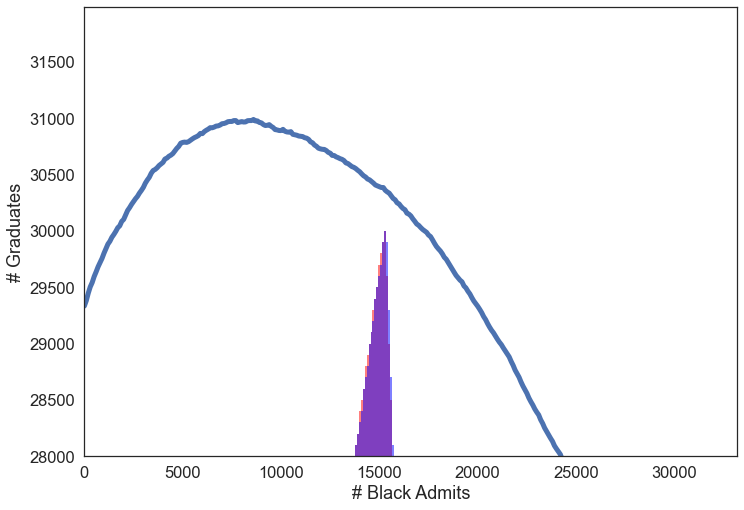

In [29]:
import seaborn as sns
import matplotlib.ticker as ticker
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(style="white", font_scale=1.5, )
ax = sns.lineplot(data=df_pareto, x='# Black Admits', y='# Graduates',linewidth=5)
errorboxes = []

for outcome_block in outcomes_grid:
    if outcome_block['policy_exists'] == 1:
        errorboxes.append(Rectangle((outcome_block['min_black_admits'] , outcome_block['min_graduates']),GRID_SIZE,GRID_SIZE))

pc = PatchCollection(errorboxes, facecolor='red', alpha=0.5,  edgecolor='none')
                       
ax.add_collection(pc)

errorboxes2 = []

for outcome_block in outcomes_grid2:
    if outcome_block['policy_exists'] == 1:
        errorboxes2.append(Rectangle((outcome_block['min_black_admits'] , outcome_block['min_graduates']),GRID_SIZE,GRID_SIZE))

pc2 = PatchCollection(errorboxes2, facecolor='blue', alpha=0.5,  edgecolor='none')
                       
ax.add_collection(pc2)


plt.scatter(x=(df['R']*0.5).sum(),y=(df['Y']*0.5).sum(),color='green')   
plt.xlim([0, MAX_BLACK_ADMITS])
plt.ylim([28000, df_pareto['# Graduates'].max()+1000])
plt.show()


    
